<a href="https://www.kaggle.com/code/maciejk111/dog-breeds-classification-nn?scriptVersionId=128344203" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

First of all I import all necessary libraries.

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import random
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

My project is a neural network that can recognize different breeds of dogs. This project was purely for fun and my desire to learn more about deep learning techniques. By training the neural network on thousands of images of different dog breeds, I was able to develop an accurate algorithm that can recognize and classify dog breeds with a high degree of accuracy. I am excited about the potential applications of this project in the field of image recognition and computer vision. With further improvements and refinements, I believe that this technology could be used in a variety of contexts to identify and classify objects in real-time.

Importing my custom dataset.


In [2]:
dataset = ImageFolder('/kaggle/input/imagesd/ImagesD')

Dividing data on training, test and validation parts. 

In [3]:
random_seed = 42
torch.cuda.manual_seed_all(random_seed)
torch.manual_seed(random_seed);

test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(f"training data length: {len(train_ds)}")
print(f"test data length: {len(test_ds)}")
print(f"validation data length: {len(val_ds)}")

training data length: 13048
test data length: 6212
validation data length: 1449


Images in my dataset are in the PIL format so i need to applay more transformations in order to get dataset with data augumentation.

80


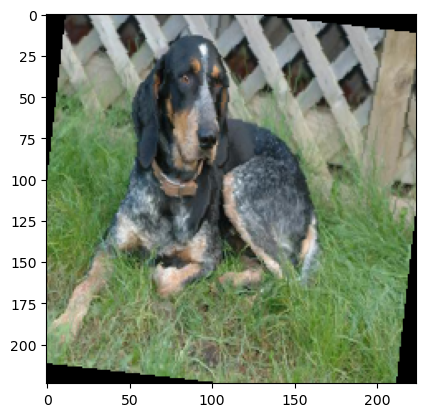

In [4]:
class Dogs_breeds_dataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label
        
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

train_dataset = Dogs_breeds_dataset(train_ds, train_transform)
val_dataset = Dogs_breeds_dataset(val_ds, val_transform)
test_dataset =Dogs_breeds_dataset(test_ds, test_transform)

img, label = train_dataset[random.randint(0,10000)]
print(label)
plt.imshow(img.permute(1,2,0))

Here i create Dataloaders.

In [5]:
batch_size =64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

Here I define neural network model with the general base class for image classification and model "wide_resnet50", which was choosen by me due to it's general good performance - it achieves good accuracy while at the same time it does not consume that much of compilatory power 

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        
        
class Dogs_breeds_WideResnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.wide_resnet50_2(pretrained=True)
        
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 121),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [7]:
model1 = Dogs_breeds_WideResnet()
model1

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

Dogs_breeds_WideResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

Here I move data to the GPU, the GPU I'm using is Tesla P100. 

In [8]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)
    
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
    
    
device = get_default_device()
print(device)

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

to_device(model1, device);

cuda


here i check the model

In [9]:
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model1(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_loader)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([116,  31, 109,  67,  33,  54,  39,   3, 102,  44,  39,  32,  28,  12,
         37, 105,  59,  30,  87,  96, 116, 110,  48,  68,  47,  75, 102,  40,
         72,  61,  75,  60,  20, 104, 109,  18,  25, 106, 115, 108, 118,  18,
         89,  71, 100,  91, 116,  44,  40, 104,   5,   6,  42,  25, 102,  86,
         32,  62, 118,  50,   5,  96,  26,  45], device='cuda:0')
outs.shape : torch.Size([64, 121])
outs :  tensor([[-4.5984, -4.9388, -4.8546,  ..., -5.0508, -4.7955, -4.5657],
        [-4.6242, -5.1653, -5.1387,  ..., -5.0492, -4.5235, -4.1291],
        [-4.5859, -5.3964, -4.7451,  ..., -4.8945, -4.5793, -4.2447],
        ...,
        [-4.3826, -4.8260, -4.8670,  ..., -4.9118, -4.6409, -4.5558],
        [-4.7001, -4.9059, -5.0776,  ..., -5.0675, -4.8704, -4.2676],
        [-4.7477, -4.9185, -4.6728,  ..., -5.2950, -4.7705, -4.2838]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


importing loading bar for better visualisation 

In [10]:
from tqdm.notebook import tqdm

Implementation of training and evaluation of my model. I have decided to use "train_one_cycle" which will change the learning rate after every batch of training

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader1, val_loader1, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader1))
    
    for epoch in range(epochs):
        
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader1):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            
           
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
        
            sched.step()
            
        result = evaluate(model, val_loader1)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader1):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader1]
    return model.validation_epoch_end(outputs)

In [12]:
evaluate(model1, val_loader)

{'val_loss': 4.869569778442383, 'val_acc': 0.0052083334885537624}

setting hyperparameters

In [13]:
num_epochs = 8
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

let that beast get started :D 

In [14]:
history = fit_one_cycle(num_epochs, max_lr, model1, train_loader, val_loader, weight_decay, grad_clip, opt_func)

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [0] : train_loss: 3.2334, val_loss: 0.9059, val_acc: 0.7883


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.8095, val_loss: 1.0912, val_acc: 0.6919


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.5936, val_loss: 1.1575, val_acc: 0.6808


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [3] : train_loss: 0.4506, val_loss: 0.8428, val_acc: 0.7519


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [4] : train_loss: 0.3117, val_loss: 0.7478, val_acc: 0.7883


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [5] : train_loss: 0.1938, val_loss: 0.5964, val_acc: 0.8198


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [6] : train_loss: 0.1088, val_loss: 0.5295, val_acc: 0.8433


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [7] : train_loss: 0.0715, val_loss: 0.5132, val_acc: 0.8425


In [15]:
num_epochs = 3
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model1, train_loader, val_loader, weight_decay, grad_clip, opt_func)

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0682, val_loss: 0.5145, val_acc: 0.8386


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0616, val_loss: 0.5023, val_acc: 0.8525


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [2] : train_loss: 0.0563, val_loss: 0.5058, val_acc: 0.8498


In [16]:
num_epochs = 2
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model1, train_loader, val_loader, weight_decay, grad_clip, opt_func)

  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [0] : train_loss: 0.0567, val_loss: 0.5100, val_acc: 0.8492


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [1] : train_loss: 0.0592, val_loss: 0.5101, val_acc: 0.8486


Visualise loss per epochs (red = validation loss, blue = training loss)

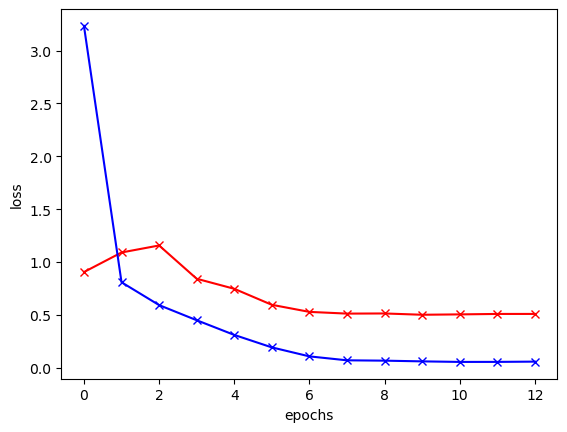

In [17]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    
    
    
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

accuracy per epochs 

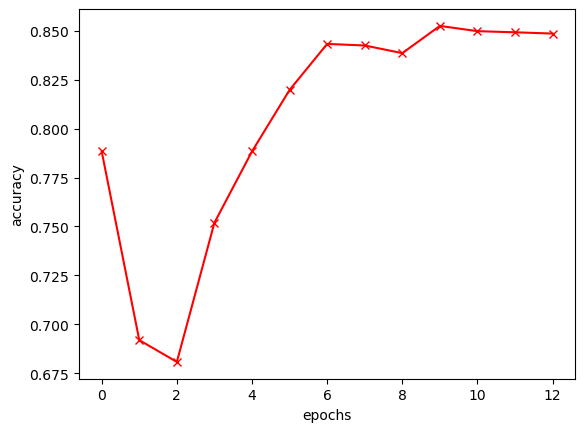

In [18]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

learning rate per epochs

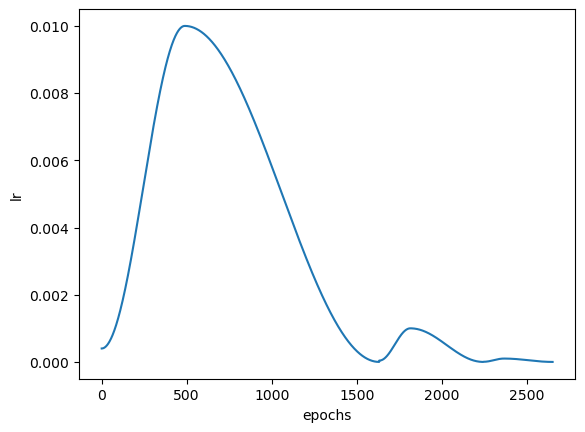

In [19]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

I realised that I forgot to create list of labels, but no worry I can do it right now, folders name have been already named correctly by me in advance, so I'm just returning its label's names. 

As you may see there are border collie and corgie does not have proper names, but it is not a mistake, it's a feature and inside joke between me and some lady. But if you need translation of the labels, then here you are: 

"thats literally me" stands for "border collie" and "awww thats totally her" stand for corgi. 


In [20]:
breeds = []

def name(name):
        return name

for n in dataset.classes:
    breeds.append(name(n))
    
breeds

['Afghan hound',
 'African hunting dog',
 'Airedale',
 'American Staffordshire terrier',
 'Appenzeller',
 'Australian terrier',
 'Bedlington terrier',
 'Bernese mountain dog',
 'Blenheim spaniel',
 'Border terrier',
 'Boston bull',
 'Bouvier des Flandres',
 'Brabancon griffon',
 'Brittany spaniel',
 'Cardigan',
 'Chesapeake Bay retriever',
 'Chihuahua',
 'Dandie Dinmont',
 'Doberman',
 'English foxhound',
 'English setter',
 'English springer',
 'EntleBucher',
 'Eskimo dog',
 'French bulldog',
 'German shepherd',
 'German short haired pointer',
 'Gordon setter',
 'Great Dane',
 'Great Pyrenees',
 'Greater Swiss Mountain dog',
 'Ibizan hound',
 'Irish setter',
 'Irish terrier',
 'Irish water spaniel',
 'Irish wolfhound',
 'Italian greyhound',
 'Japanese spaniel',
 'Kerry blue terrier',
 'Labrador retriever',
 'Lakeland terrier',
 'Leonberg',
 'Lhasa',
 'Maltese dog',
 'Mexican hairless',
 'Newfoundland',
 'Norfolk terrier',
 'Norwegian elkhound',
 'Norwich terrier',
 'Old English sheepd

Let's predict some doggos from the test dataset

In [21]:
def predict_single(img, label):
    xb = img.unsqueeze(0) 
    xb = to_device(xb, device)
    preds = model1(xb)                   
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

ok lets try out my model

Actual : chow  | Predicted : Tibetan mastiff


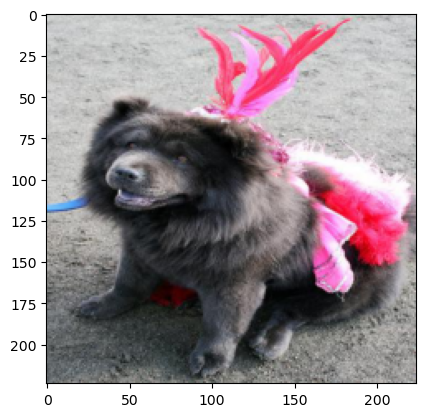

In [22]:
predict_single(*test_dataset[2])

XDDD ok first try and such a fail... what a failure.... 
but lets be honest those breeds looks the same, human would not guess correctly not to mention AI created by a student... lets try again

Actual : Gordon setter  | Predicted : Gordon setter


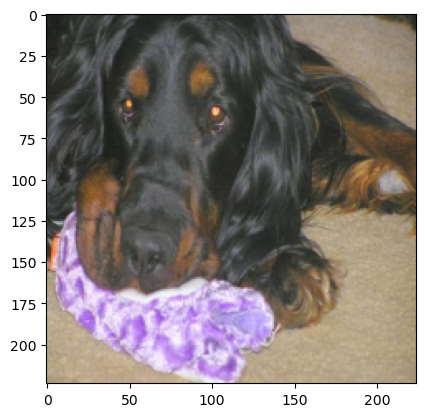

In [23]:
predict_single(*test_dataset[232])

now its working B-)) 

ok but lets predict some more, lets say 10 with random labels 

Actual : Afghan hound  | Predicted : Afghan hound


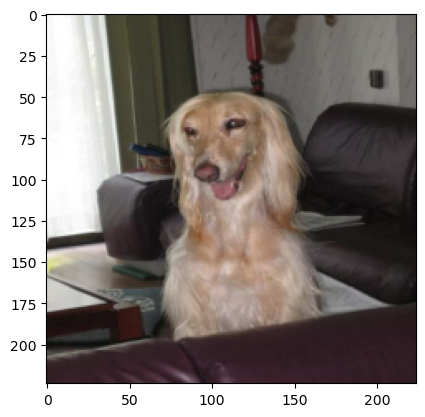

Actual : otterhound  | Predicted : otterhound


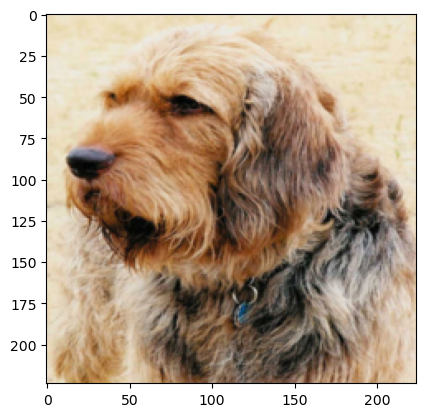

Actual : Sealyham terrier  | Predicted : Sealyham terrier


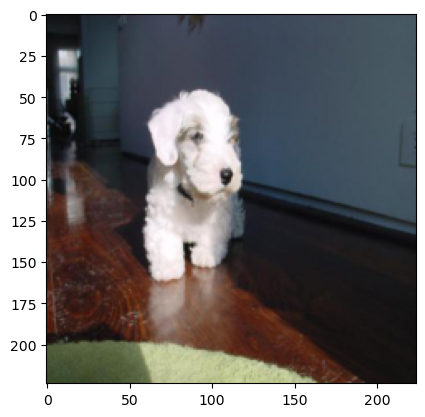

Actual : Sussex spaniel  | Predicted : Rhodesian ridgeback


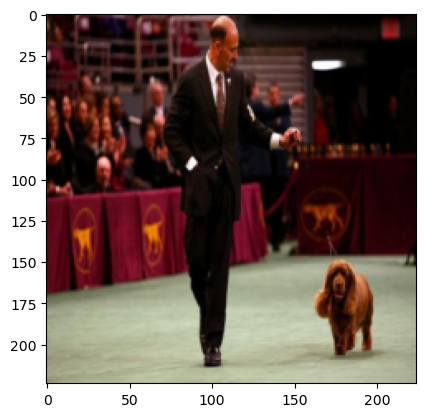

Actual : Walker hound  | Predicted : English foxhound


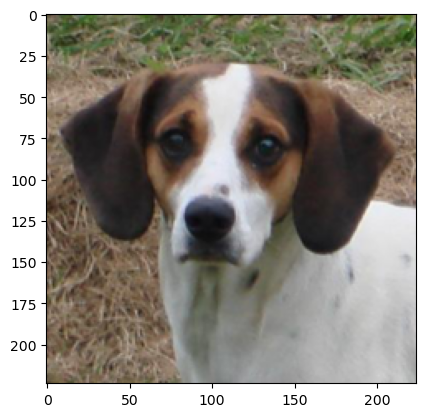

Actual : Greater Swiss Mountain dog  | Predicted : Greater Swiss Mountain dog


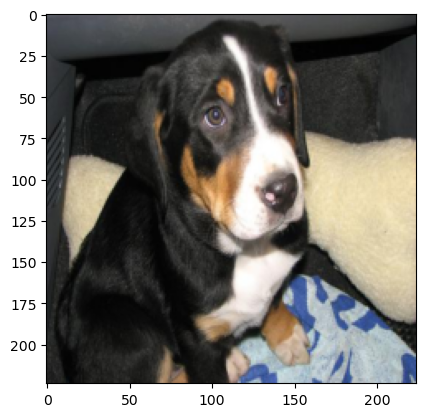

Actual : Italian greyhound  | Predicted : Italian greyhound


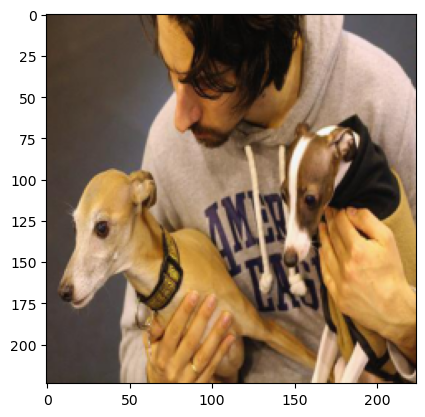

Actual : Maltese dog  | Predicted : Maltese dog


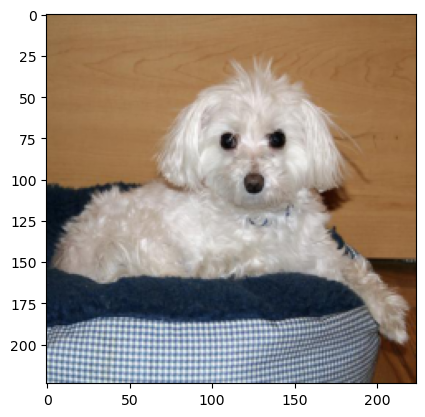

Actual : West Highland white terrier  | Predicted : West Highland white terrier


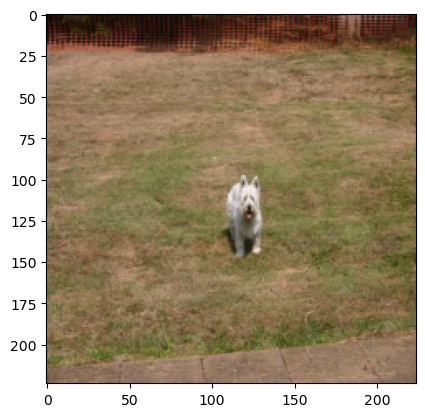

Actual : miniature poodle  | Predicted : standard poodle


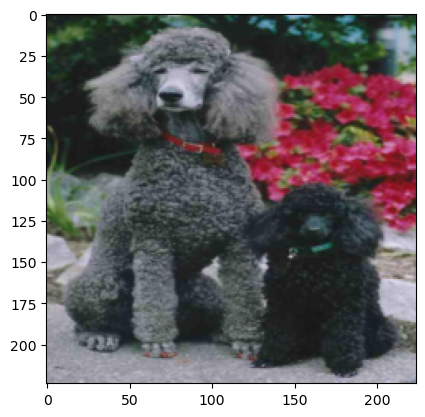

In [24]:
import random

for i in range(10):
    # get label between 1 and 6212 which is the size of my test dataset
    random_label = random.randint(1,6212 )
    img, label = test_dataset[random_label]
    predict_single(img, label)

My model just nailed that test! Great! 

Actual : awww thats totally her  | Predicted : awww thats totally her


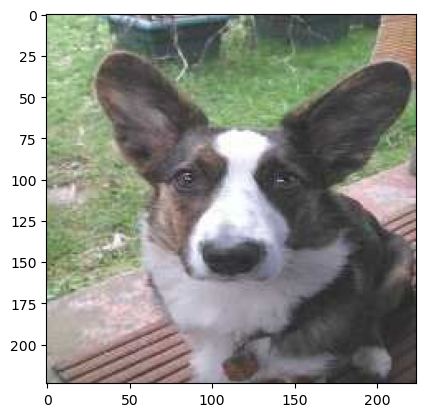

In [25]:
predict_single(*test_dataset[28])

aww thats totally her, even thought it's the ugliest corgie i have ever seen 

Lets's call evaluate on the test dataloader 

In [26]:
test_dl = DeviceDataLoader(test_loader, device)
result = evaluate(model1, test_dl)
result

{'val_loss': 0.49156635999679565, 'val_acc': 0.854057252407074}

Level of accuracy on the test dataset = 85,61%. Pretty good, huh? 

now let's save our model

In [27]:
weights_fname = 'Dog_breed_classification-wideresnet_with_Daug02.pth'
torch.save(model1.state_dict(), weights_fname)

In [28]:
from torch.utils.data import Dataset

from json import JSONEncoder
import json

class EncodeTensor(JSONEncoder,Dataset):
    def default(self, obj):
        if isinstance(obj, torch.Tensor):
            return obj.cpu().detach().numpy().tolist()
        return super(NpEncoder, self).default(obj)

with open('torch_weights22.json', 'w') as json_file:
    json.dump(model1.state_dict(), json_file,cls=EncodeTensor)

In [29]:
e = 2
r = 4
e + r

6